# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorrt
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

# PCA

In [24]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([tf.keras.layers.Input(shape=(3), dtype=tf.float32), encoder, decoder])

optimizer = tf.keras.optimizers.SGD()
autoencoder.compile(loss='mse', optimizer=optimizer)
x = datasets.load_iris()
x_train = x['data'][:, :3]
history = autoencoder.fit(x_train, x_train, epochs=500, verbose=False)
codings = autoencoder.predict(x_train)

5/5 [==============================] - 0s 1ms/step


In [28]:
tf.reduce_mean(codings - x_train)

<tf.Tensor: shape=(), dtype=float64, numpy=-0.0011958465046352752>

# Stacked Autoencoders

In [3]:
(x_train, y_train), (x_valid, y_valid) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_valid = x_valid / 255.0

In [ ]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])
stacked_autoencoder = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_autoencoder.compile(loss='mse', optimizer='nadam')
# Using x_train and x_valid for both training and labels (hence autoencoding)
history = stacked_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

1/1 [==============================] - 0s 44ms/step


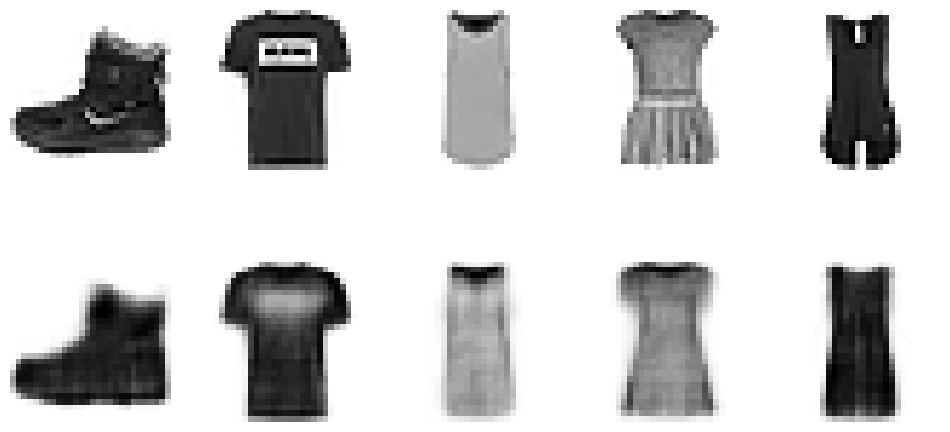

In [45]:
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
encoded = stacked_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        else:
            image = encoded[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

313/313 [==============================] - 0s 1ms/step


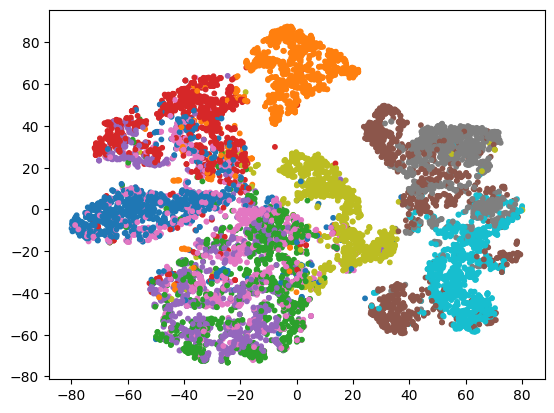

In [46]:
from sklearn.manifold import TSNE

x_valid_compressed = stacked_encoder.predict(x_valid)
tsne = TSNE(init='pca', learning_rate='auto', random_state=42)
x_valid_2d = tsne.fit_transform(x_valid_compressed)

plt.scatter(x_valid_2d[:, 0], x_valid_2d[:, 1], c=y_valid, s=10, cmap='tab10')
plt.show()

# Tying weights

In [51]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense: tf.keras.layers.Dense = dense
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        self.biases = self.add_weight(name='bias', shape=self.dense.input_shape[-1], initializer='zeros')
        return super().build(input_shape)
    
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [52]:
dense_1 = tf.keras.layers.Dense(100, activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    dense_1, 
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation='relu'),
    # This projects 100 -> 28x28, as 28x28 was the implicit input of dense_1
    DenseTranspose(dense_1, activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])
tied_autoencoder = tf.keras.Sequential([tied_encoder, tied_decoder])

tied_autoencoder.compile(loss='mse', optimizer='nadam')
tied_history = tied_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0237 - val_loss: 0.0167
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.

1/1 [==============================] - 0s 122ms/step


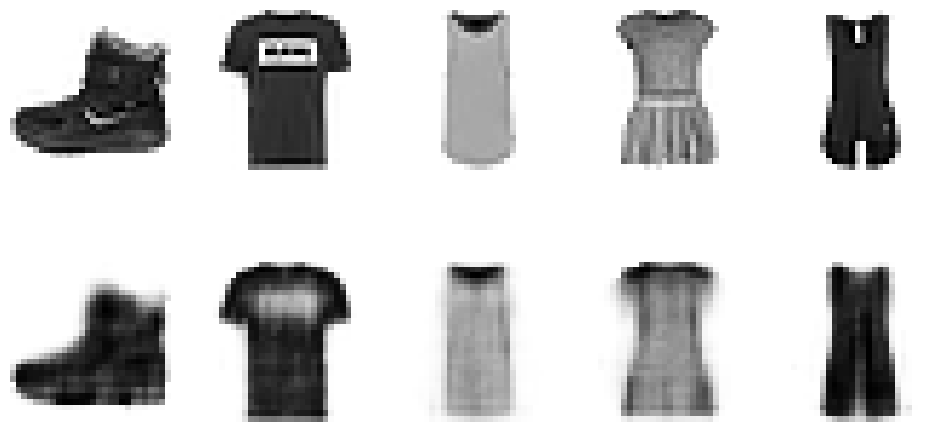

In [58]:
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
encoded = tied_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        else:
            image = encoded[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

# Convolutional Autoencoders

In [56]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (14, 14, 16)
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (7, 7, 32) 
    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: (3, 3, 64)
    tf.keras.layers.Conv2D(30, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GlobalAvgPool2D()        # output: 30
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    # Upsampling the images
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu'),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])

conv_autoencoder = tf.keras.Sequential([conv_encoder, conv_decoder])
conv_autoencoder.compile(loss='mse', optimizer='nadam')
history = conv_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1875/1875 [==============================] - 24s 11ms/step - loss: 0.0323 - val_loss: 0.0205
Epoch 2/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 3/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0163 - val_loss: 0.0153
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 7/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 8/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 9/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 10/20
1875/1875 [==============================] - 19s 10m

1/1 [==============================] - 0s 120ms/step


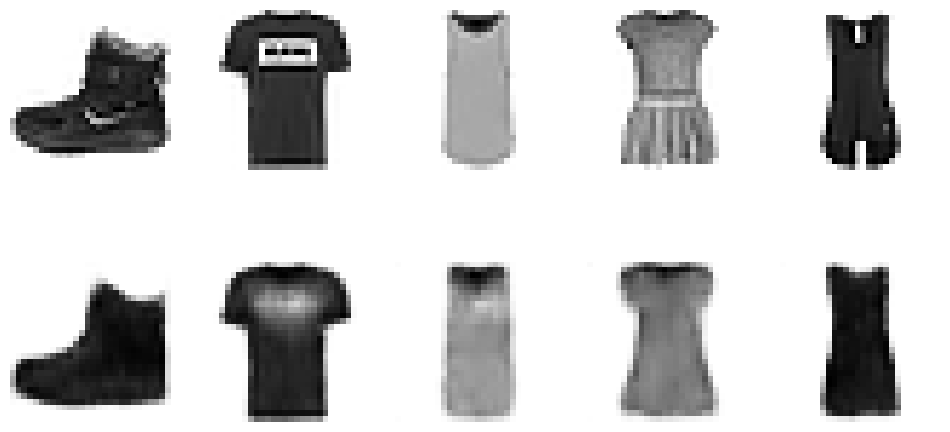

In [57]:
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
encoded = conv_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        else:
            image = encoded[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

In [70]:
print(conv_encoder.predict(x_train[:1])[0])

1/1 [==============================] - 0s 16ms/step
[ 4.786354   4.7296557  0.         7.4468174  7.6902137  0.
  5.5177755  8.749788   2.3760052  4.2687798  4.795691  15.313154
 10.449205   9.904245  10.463114   0.        13.010611  10.043542
 11.763061   3.1331773  6.4286804  8.482572   8.689672   4.4221377
  1.6629912  4.0470715  0.         4.9020443  4.791022  11.196897 ]


# Denoising Autoencoders

In [5]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'), # sigmoid is mine
    tf.keras.layers.Reshape([28, 28])
])
dropout_autoencoder = tf.keras.Sequential([dropout_encoder, dropout_decoder])

dropout_autoencoder.compile(loss='mse', optimizer='nadam')
history = dropout_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1875/1875 [==============================] - 28s 7ms/step - loss: 0.0281 - val_loss: 0.0182
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0192 - val_loss: 0.0161
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0177 - val_loss: 0.0151
Epoch 4/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0169 - val_loss: 0.0145
Epoch 5/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0165 - val_loss: 0.0140
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0161 - val_loss: 0.0138
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0159 - val_loss: 0.0135
Epoch 8/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0157 - val_loss: 0.0135
Epoch 9/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 10/20
1875/1875 [==============================] - 13s 7ms/step - l

1/1 [==============================] - 0s 22ms/step


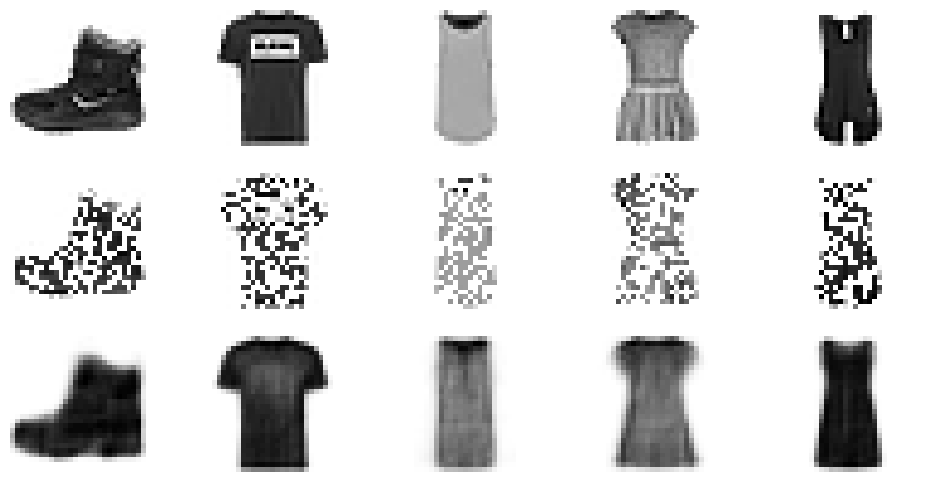

In [10]:
n_rows = 3
n_cols = 5

example_noise = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Reshape([28, 28])
])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
encoded = example_noise(original, training=True)
autoencoded = dropout_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        elif row == 1:
            image = encoded[col]
        elif row == 2:
            image = autoencoded[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

# Sparse autoencoders

## Using regularization

In [11]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    # Apply L1 regularization to push neurons to 0. Can also do: activity_regularizer=tf.keras.regularizers.l1(1e-4)
    tf.keras.layers.Dense(300, activation='sigmoid'),
    # The layer returns its inputs but as a side-effect adds L1 regularization to the model's training loss
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])

# Usual decoder
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28), 
    tf.keras.layers.Reshape([28, 28])
])

sparse_l1_autoencoder = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_autoencoder.compile(loss='mse', optimizer='nadam')
history = sparse_l1_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1875/1875 [==============================] - 17s 8ms/step - loss: 0.0276 - val_loss: 0.0190
Epoch 2/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0171 - val_loss: 0.0156
Epoch 3/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 4/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 5/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0130 - val_loss: 0.0127
Epoch 6/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 7/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 8/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 10/20
1875/1875 [==============================] - 15s 8ms/step - l

1/1 [==============================] - 0s 74ms/step


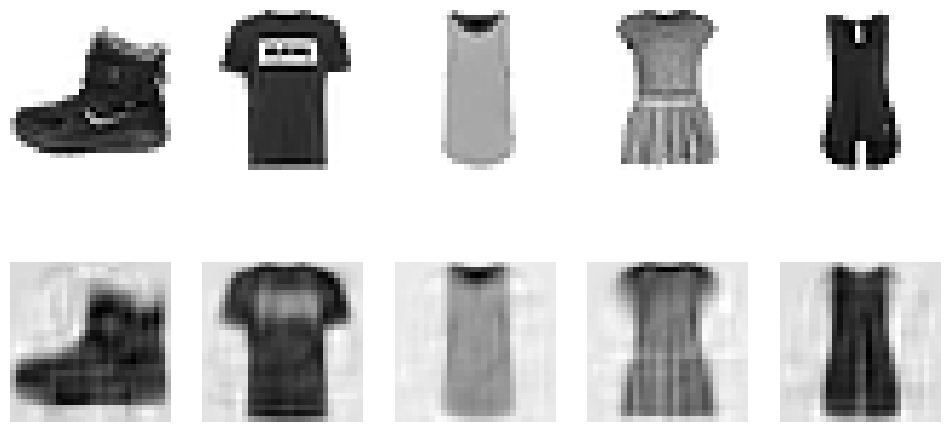

In [12]:
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
encoded = sparse_l1_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        else:
            image = encoded[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

## Training the encoder on target sparsity

In [70]:
print(tf.keras.losses.kl_divergence([0, 1], [0.5, 0.5]).numpy())
print(
    tf.keras.losses.kl_divergence([0], [0.5]).numpy() + 
    tf.keras.losses.kl_divergence([1-0], [1-0.5]).numpy() 
) 

0.69314563
0.69314563


In [67]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target) -> None:
        self.weight = weight
        self.target = target

    # inputs ~ (batch size, units)
    def __call__(self, inputs):
        # mean_activities ~ (units)
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            # kl_divergence already performs a sum on the units (which is what we want)
            # but we need to do it to the complete so that all events of the binomial distributions
            # are accounted for
            tf.keras.losses.kl_divergence(self.target, mean_activities) + 
            tf.keras.losses.kl_divergence(1. - self.target, 1. - mean_activities)
        )
    
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)

sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg),
])

sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28), 
    tf.keras.layers.Reshape([28, 28])
])

sparse_kl_autoencoder = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_autoencoder.compile(loss='mse', optimizer='nadam')
history = sparse_kl_autoencoder.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1875/1875 [==============================] - 19s 9ms/step - loss: 0.0247 - val_loss: 0.0164
Epoch 2/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0146 - val_loss: 0.0130
Epoch 3/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 4/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 5/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 6/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 7/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 8/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 9/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 10/20
1875/1875 [==============================] - 16s 8ms/step - l

1/1 [==============================] - 0s 19ms/step


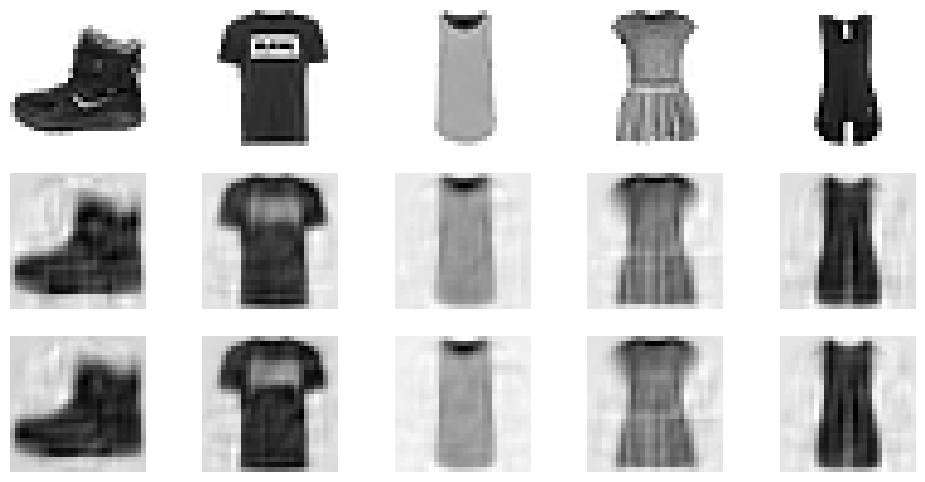

In [72]:
n_rows = 3
n_cols = 5

example_noise = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Reshape([28, 28])
])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
original = x_train[:n_cols]
sparse_l1 = sparse_l1_autoencoder.predict(original)
sparse_kl = sparse_kl_autoencoder.predict(original)

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        if row == 0:
            image = original[col]
        elif row == 1:
            image = sparse_l1[col]
        elif row == 2:
            image = sparse_kl[col]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

# Variational Autoencoders

In [4]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        # log_var := log(σ^2) = 2*log(σ)
        # => log_var / 2 = log(σ)
        # => exp(log_var / 2) = σ
        mean, log_var = inputs
        return tf.random.normal(shape=tf.shape(log_var)) * tf.exp(log_var / 2) + mean
    
coding_size = 10
inputs = tf.keras.layers.Input(shape=[28, 28])

Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation='relu')(Z)
Z = tf.keras.layers.Dense(100, activation='relu')(Z)
# We are essentially learning μ and log(σ^2)
codings_mean = tf.keras.layers.Dense(coding_size)(Z)     # μ 
codings_log_var = tf.keras.layers.Dense(coding_size)(Z)  # γ
coding = Sampling()([codings_mean, codings_log_var])

# We output codings_mean and codings_log_var just so we can inspect them
variational_encoder = tf.keras.Model(
    inputs=[inputs], 
    outputs=[codings_mean, codings_log_var, coding]
)


variational_decoder = tf.keras.Sequential([
    tf.keras.layers.Input([coding_size]),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'),  # sigmoid is mine
    tf.keras.layers.Reshape([28, 28]),
])

_, _, coding = variational_encoder(inputs)
reconstructions = variational_decoder(coding)
variational_autoencoder = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# Calculate the sum of losses across the latent dimensions. We get one loss per sample.
latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)

# MSE loss calculates the MSE per sample first: tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2])
# and then calcualtes the average of that across samples: tf.reduce_mean(_)
# For latent loss, we also calculate the average across samples, but to make sure it is the same
# magnitude as the reconstruction loss, we divide by 784, as we only reduce_sum.
# This means we should use a larger learning rate, as the loss is 784x smaller than the formula.
# Alternatively, we can create a custom loss for the reconstruction loss that computes sum instead of mean.
variational_autoencoder.add_loss(tf.reduce_mean(latent_loss) / 784.)

variational_autoencoder.compile(loss='mse', optimizer='nadam')
variational_autoencoder.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_valid, x_valid))



Epoch 1/25
469/469 [==============================] - 10s 9ms/step - loss: 0.0530 - val_loss: 0.0389
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0371 - val_loss: 0.0357
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0350 - val_loss: 0.0345
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0339 - val_loss: 0.0337
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0333 - val_loss: 0.0332
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0328 - val_loss: 0.0327
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 8/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0322 - val_loss: 0.0321
Epoch 9/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0320 - val_loss: 0.0321
Epoch 10/25
469/469 [==============================] - 4s 9ms/step - loss: 0.0318 - val_loss: 0.031

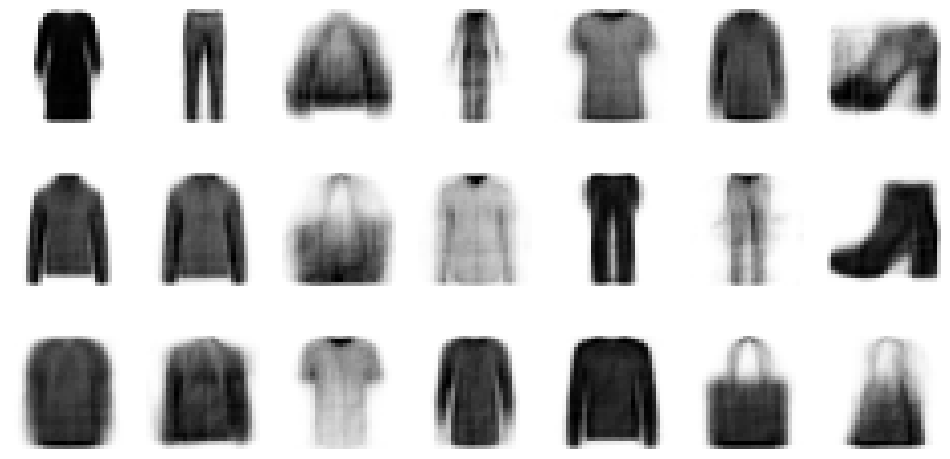

In [89]:
n_rows = 3 
n_cols = 7

codings = tf.random.normal(shape=[n_rows * n_cols, coding_size])
images = variational_decoder(codings).numpy()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        image = images[col + row * n_cols]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

1/1 [==============================] - 0s 16ms/step


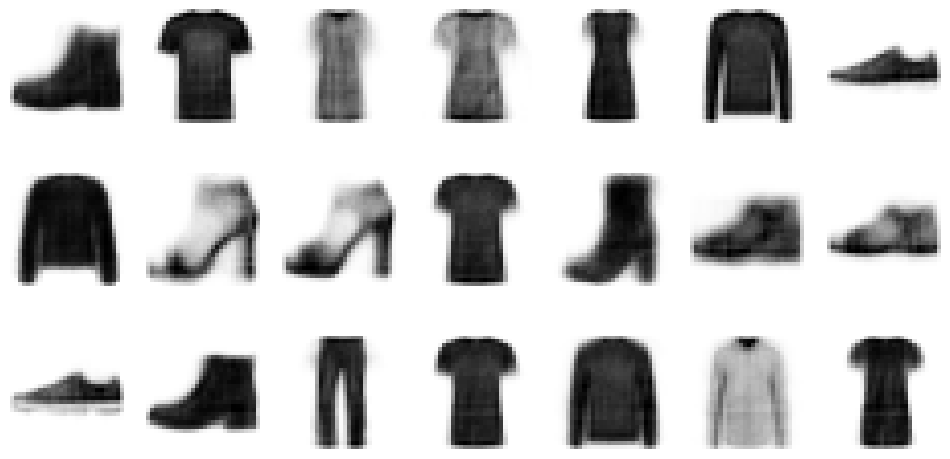

In [8]:
n_rows = 3 
n_cols = 7

source_images = x_train[:n_rows * n_cols]
_, _, codings = variational_encoder.predict(source_images)
images = variational_decoder(codings).numpy()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        image = images[col + row * n_cols]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

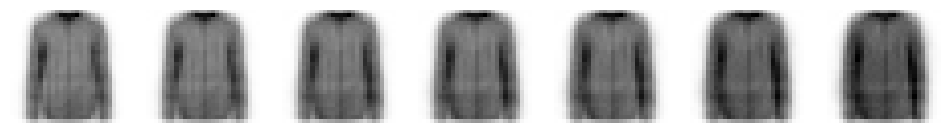

In [88]:
n_images = 7
codings = np.zeros([n_images, coding_size])
codings[:, 2] = np.linspace(-0.8, 0.8, n_images)
images = variational_decoder(codings).numpy()

fig, axes = plt.subplots(1, n_images, figsize=(12, 6))

for idx, image in enumerate(images):
    ax: plt.Axes = axes[idx]
    ax.imshow(image, cmap='binary')
    ax.set_axis_off()

# GAN

## Basic GAN

In [3]:
codings_size = 30

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(150, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

gan = tf.keras.Sequential([generator, discriminator])

# The trainable attribute is taken into account by Keras only when compiling the model.
# So calling discriminator.fit() or discriminator.train_on_batch() WILL train the model,
# while calling gan.fit() or gan.train_on_batch() will not.
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

batch_size = 24
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(x_train, dtype=tf.float32)).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for x_batch in dataset:
            # Phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(x_fake_and_real, y1)
            print('.', end='')
            # Phase 2 - training the generator (the discriminator is not trainable)
            # We want to beat the discriminator, hence targets are all set to 1.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([1.] * batch_size)
            gan.train_on_batch(noise, y2)
            print('.', end='')
        print()
        print(f'Done epoch {epoch}/{n_epochs}')

train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/dense_3/MatMul/MatMul' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9343/3103133552.py", line 50, in <module>
      train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)
    File "/tmp/ipykernel_9343/3103133552.py", line 39, in train_gan
      discriminator.train_on_batch(x_fake_and_real, y1)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 2510, in train_on_batch
      logs = self.train_function(iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 542, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/optimizers/optimizer.py", line 275, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential_1/dense_3/MatMul/MatMul'
OOM when allocating tensor with shape[784,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/dense_3/MatMul/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_821]

In [ ]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

## Deep Convolutional GAN (DCGAN)

In [22]:
def create_spinner():
    next_rotation = 0
    steps = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    def spin():
        nonlocal next_rotation
        print(f'\r{steps[next_rotation]}', end='')
        next_rotation = (next_rotation + 1) % len(steps)
    return spin

In [18]:
codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gan = tf.keras.Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

batch_size = 24
# Since the generator's last layer is tanh
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
dataset = tf.data.Dataset.from_tensor_slices(tf.cast(x_train_dcgan, dtype=tf.float32)).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

next_rotation = 0
steps = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
def rotate():
    global next_rotation
    print(f'\r{steps[next_rotation]}', end='')
    next_rotation = (next_rotation + 1) % len(steps)


def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for x_batch in dataset:
            # Phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(x_fake_and_real, y1)
            rotate()
            # Phase 2 - training the generator (the discriminator is not trainable)
            # We want to beat the discriminator, hence targets are all set to 1.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([1.] * batch_size)
            gan.train_on_batch(noise, y2)
            rotate()
        print()
        print(f'Done epoch {epoch}/{n_epochs}')

In [19]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

\
Done epoch 0/50
\
Done epoch 1/50
\
Done epoch 2/50
\
Done epoch 3/50
\
Done epoch 4/50
\
Done epoch 5/50
\
Done epoch 6/50
\
Done epoch 7/50
\
Done epoch 8/50
\
Done epoch 9/50
\
Done epoch 10/50
\
Done epoch 11/50
\
Done epoch 12/50
\
Done epoch 13/50
\
Done epoch 14/50
\
Done epoch 15/50
\
Done epoch 16/50
\
Done epoch 17/50
\
Done epoch 18/50
\
Done epoch 19/50
\
Done epoch 20/50
\
Done epoch 21/50
\
Done epoch 22/50
\
Done epoch 23/50
\
Done epoch 24/50
\
Done epoch 25/50
\
Done epoch 26/50
\
Done epoch 27/50
\
Done epoch 28/50
\
Done epoch 29/50
\
Done epoch 30/50
\
Done epoch 31/50
\
Done epoch 32/50
\
Done epoch 33/50
\
Done epoch 34/50
\
Done epoch 35/50
\
Done epoch 36/50
\
Done epoch 37/50
\
Done epoch 38/50
\
Done epoch 39/50
\
Done epoch 40/50
\
Done epoch 41/50
\
Done epoch 42/50
\
Done epoch 43/50
\
Done epoch 44/50
\
Done epoch 45/50
\
Done epoch 46/50
\
Done epoch 47/50
\
Done epoch 48/50
\
Done epoch 49/50


In [20]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 1s 563ms/step


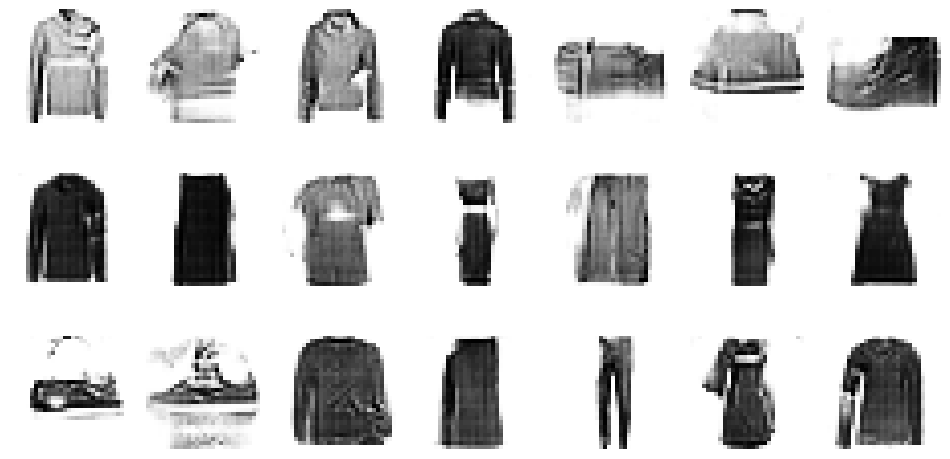

In [21]:
n_rows = 3
n_cols = 7

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        image = generated_images[col + row * n_cols]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

# Diffusion models

In [40]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    # This is the definition of alpha: αt = f(t)/f(t-1)
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    # Beta is defined as 1-alpha. So symmetric clipping of 
    # alpha is the same as clipping beta.
    beta = 1 - alpha
    # Is is the definition of "α bar"
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

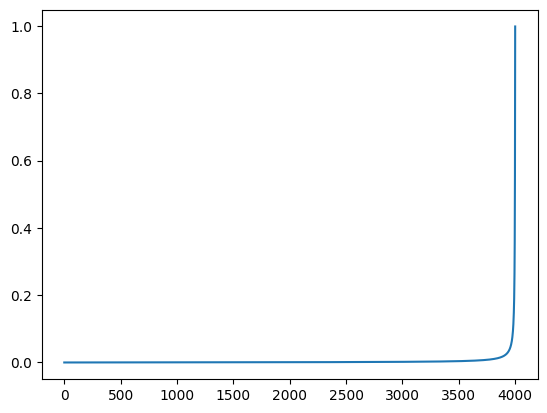

In [63]:
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)
fig, ax = plt.subplots()
ax.plot(beta)

In [44]:
def prepare_batch(X):
    # Add a channel axis and scale from -1 to +1 to be close to gaussian distribution
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1
    X_shape = tf.shape(X)
    # Produce a vector of batch size number of samples, filled with 
    # random time steps between 1 and T
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    # Get alpha_cumprod for each timestep in vector t
    alpha_cm = tf.gather(alpha_cumprod, t)
    # Reshape alpha_cm from [batch size] to [batch size, 1, 1, 1] to allow broadcasting.
    # When X ~ (32, 28, 28, 1) like in MNIST, alpha_cm ~ (32, 1, 1, 1)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        # Apply the noise to the image. The same noise factor is applied to all pixels in 
        # the same sample. Remember that z=(x-µ)/σ, so x=zσ+µ. 
        # The formula to determine the noisy image xt given the original x0 (X in our case) is:
        # q(xt|x0) = N(sqrt(alpha_bar(t))*x0, (1-alpha_bar(t))I)
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t
    }, noise

In [45]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

train_set = prepare_dataset(x_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(x_valid, batch_size=32)

Original images


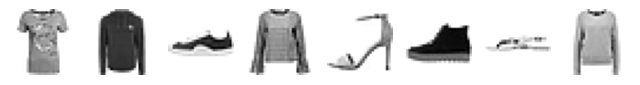

Time steps: [3246  920 1716 1700 3871  596 3691    3]
Noisy images


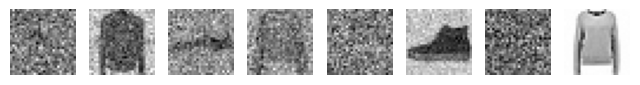

Noise to predict


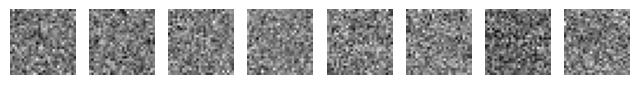

In [62]:
# extra code – just a quick sanity check

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:8])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

In [49]:
# The model must be aware of which time step we are in when receiving a noisy image. 
# Here we encode the time step using a similar fashion to how it was done with Transformers.
embed_size = 64
class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)
    
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name='X_noisy')
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name='time')
    # Can be any model as long as it takes the noisy image and time steps as input and predicts
    # noise to subtract from the input images. Here we can use our time encoding to start:
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])


In [50]:
folder = Path() / 'data' / 'diffusion'
tensorboard_dir = folder / 'tensorboard'
print(f'tensorboard --logdir=ch17/{tensorboard_dir}')
tensorboard_cb = tf.keras.callbacks.TensorBoard(tensorboard_dir)
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(folder / 'checkpoints', save_best_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer='nadam')
history = model.fit(
    train_set, 
    validation_data=valid_set, 
    epochs=100, 
    callbacks=[tensorboard_cb, checkpoints_cb, early_stop_cb]
)

tensorboard --logdir=ch17/data/diffusion/tensorboard
Epoch 1/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0993

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 93s 40ms/step - loss: 0.0993 - val_loss: 0.0676
Epoch 2/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0612

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 64s 34ms/step - loss: 0.0612 - val_loss: 0.0544
Epoch 3/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0519

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 69s 37ms/step - loss: 0.0519 - val_loss: 0.0490
Epoch 4/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0484

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 66s 35ms/step - loss: 0.0484 - val_loss: 0.0475
Epoch 5/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0464

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 65s 35ms/step - loss: 0.0464 - val_loss: 0.0460
Epoch 6/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0454

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 66s 35ms/step - loss: 0.0454 - val_loss: 0.0444
Epoch 7/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0442 - val_loss: 0.0444
Epoch 8/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0433

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0433 - val_loss: 0.0426
Epoch 9/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0431 - val_loss: 0.0436
Epoch 10/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0427

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0427 - val_loss: 0.0417
Epoch 11/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0422 - val_loss: 0.0435
Epoch 12/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0417

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 35ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 13/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0417 - val_loss: 0.0424
Epoch 14/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0414

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 65s 35ms/step - loss: 0.0414 - val_loss: 0.0414
Epoch 15/100
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0411 - val_loss: 0.0417
Epoch 16/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0414

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 64s 34ms/step - loss: 0.0413 - val_loss: 0.0408
Epoch 17/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0409

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 64s 34ms/step - loss: 0.0409 - val_loss: 0.0408
Epoch 18/100
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0411 - val_loss: 0.0411
Epoch 19/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0408 - val_loss: 0.0423
Epoch 20/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0408

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0408 - val_loss: 0.0401
Epoch 21/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0404

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0404 - val_loss: 0.0400
Epoch 22/100
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0405 - val_loss: 0.0407
Epoch 23/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0403 - val_loss: 0.0403
Epoch 24/100
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0403 - val_loss: 0.0404
Epoch 25/100
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0398 - val_loss: 0.0403
Epoch 26/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0398

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 68s 36ms/step - loss: 0.0398 - val_loss: 0.0397
Epoch 27/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0401 - val_loss: 0.0410
Epoch 28/100
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0405 - val_loss: 0.0403
Epoch 29/100
1875/1875 [==============================] - ETA: 0s - loss: 0.0398

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0398 - val_loss: 0.0395
Epoch 30/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0395

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 67s 36ms/step - loss: 0.0395 - val_loss: 0.0391
Epoch 31/100
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0397 - val_loss: 0.0391
Epoch 32/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0401 - val_loss: 0.0400
Epoch 33/100
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0398 - val_loss: 0.0393
Epoch 34/100
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0397 - val_loss: 0.0396
Epoch 35/100
1874/1875 [============================>.] - ETA: 0s - loss: 0.0397

INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


INFO:tensorflow:Assets written to: data/diffusion/checkpoints/assets


1875/1875 [==============================] - 66s 35ms/step - loss: 0.0397 - val_loss: 0.0387
Epoch 36/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0395 - val_loss: 0.0397
Epoch 37/100
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0397 - val_loss: 0.0390
Epoch 38/100
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0394 - val_loss: 0.0397
Epoch 39/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0392 - val_loss: 0.0396
Epoch 40/100
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0396 - val_loss: 0.0401
Epoch 41/100
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0390 - val_loss: 0.0397
Epoch 42/100
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0391 - val_loss: 0.0397
Epoch 43/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0392 - val_loss: 0.0409
Epoch 44/100
1875/1875 [==============================] - 5

In [69]:
# To generate, we use equation 17-8
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise     # 1-alpha is the same as beta
        )
    return X

X_gen = generate(model)

t = 1    

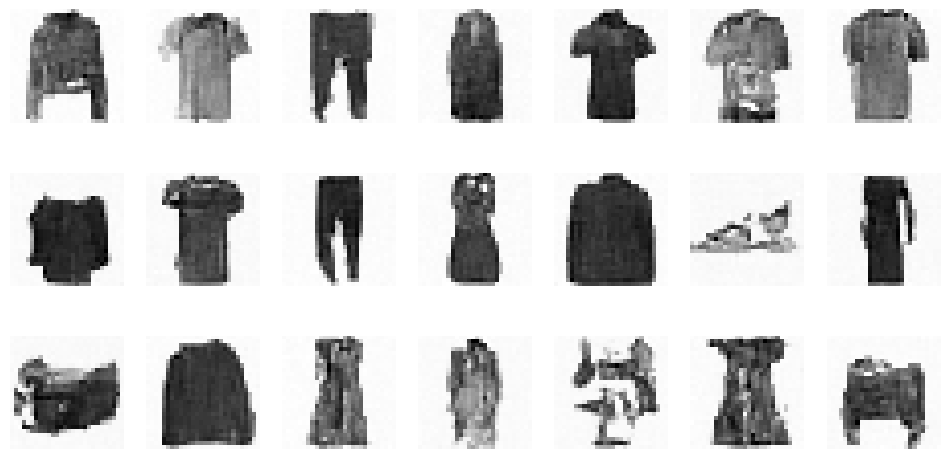

In [70]:
n_rows = 3
n_cols = 7

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        image = X_gen[col + row * n_cols]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()

In [74]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + beta[t] ** 0.5 * noise
        )
    return X

X_gen2 = generate(model)

t = 1    

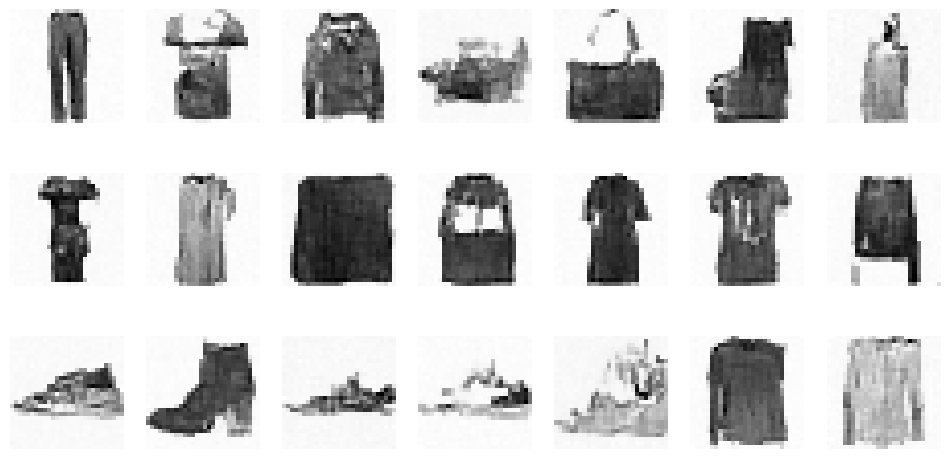

In [76]:
n_rows = 3
n_cols = 7

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))

for row in range(n_rows):
    for col in range(n_cols):
        ax: plt.Axes = axes[row][col]
        image = X_gen2[col + row * n_cols]
        ax.imshow(image, cmap='binary')
        ax.set_axis_off()